## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [3]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-21 14:04:00--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-21 14:04:01--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [4]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.9MB/s]


Text(0.5, 1.0, 'Image label: 9')

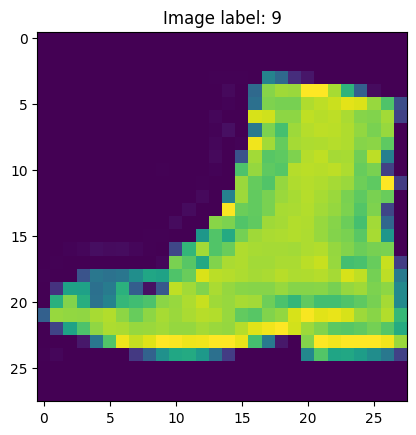

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [9]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.dp_three = nn.Dropout(0.2)
      self.dp_four = nn.Dropout(0.2)

      self.bn_one = nn.BatchNorm2d(1)
      self.conv1 = nn.Conv2d(1, 50, 3)
      self.bn_two = nn.BatchNorm2d(50)
      self.conv2 = nn.Conv2d(50, 100, 3)
      self.bn_three = nn.BatchNorm2d(100)
      self.conv3 = nn.Conv2d(100, 200, 3)
      self.bn_four = nn.BatchNorm2d(200)

      self.fc1 = nn.Linear(200, 100)
      self.fc2 = nn.Linear(100, 50)
      self.out = nn.Linear(50, 10)

  def forward(self, x):
    x = self.bn_one(x)
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.bn_two(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)


    x = self.bn_three(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)

    x = self.bn_four(x)
    x = x.view(x.size(0), -1)
    x = self.dp_three(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dp_four(x)
    x = self.fc2(x)
    x= F.relu(x)
    return  self.out(x)

In [10]:
# Creating model instance
model_task_1 = Net()
# your code here

Не забудьте перенести модель на выбранный `device`!

In [11]:
model_task_1.to(device)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 50, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [12]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
# your code here

In [ ]:
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

In [ ]:
for epoch in tqdm(range(10)):
    model_task_1.train()
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model_task_1(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model_task_1.eval()
    loss_accumed = 0
    for batch in test_data_loader:
        output = model_task_1(batch[0].to(device))
        loss = criterion(output, batch[1].to(device))
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 10%|█         | 1/10 [00:17<02:36, 17.40s/it]

Epoch 0 valid_loss 123.56322479248047


 20%|██        | 2/10 [00:33<02:14, 16.82s/it]

Epoch 1 valid_loss 109.86273193359375


 30%|███       | 3/10 [00:51<01:59, 17.08s/it]

Epoch 2 valid_loss 102.9675521850586


 40%|████      | 4/10 [01:07<01:40, 16.76s/it]

Epoch 3 valid_loss 105.06083679199219


 50%|█████     | 5/10 [01:23<01:22, 16.59s/it]

Epoch 4 valid_loss 99.00265502929688


 60%|██████    | 6/10 [01:40<01:05, 16.50s/it]

Epoch 5 valid_loss 97.18293762207031


 70%|███████   | 7/10 [01:57<00:50, 16.81s/it]

Epoch 6 valid_loss 99.45088958740234


 80%|████████  | 8/10 [02:13<00:33, 16.65s/it]

Epoch 7 valid_loss 133.7134246826172


 90%|█████████ | 9/10 [02:30<00:16, 16.53s/it]

Epoch 8 valid_loss 90.27642822265625


100%|██████████| 10/10 [02:46<00:00, 16.64s/it]

Epoch 9 valid_loss 91.39521789550781
Training is finished!


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.93583


In [ ]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.901


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hw_fmnist_data_dict.npy to hw_fmnist_data_dict.npy


Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


In [ ]:
from google.colab import files
files.download('submission_dict_fmnist_task_1.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!